In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import scipy.special as sp
import math

In [2]:
# Defining the Hamiltonian XY model

def Hamiltonian2D(J, L):
    Hamiltonian2D = 0.
    n = np.shape(L)[0]
    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            Hamiltonian2D -= J * ((np.cos(L[x, y] - L[x, (y+1)%n])) + (np.cos(L[x, y] - L[x, (y-1)%n])) 
                                  + (np.cos(L[x, y] - L[(x+1)%n, y])) + (np.cos(L[x, y] - L[(x-1)%n, y])))
    
    
    return Hamiltonian2D/2

# Defining the artifical Hamiltonian XY model

def Hamiltonian2D_art(J, L, P, beta):
    n = np.shape(L)[0]
    Hamiltonian2D_art = sum(sum(P**2))/2 + beta*Hamiltonian2D(J, L)
    return Hamiltonian2D_art


def P_dot_i_2D(J, L,beta):
    n = np.shape(L)[0]
    P_dot_i_2D = np.zeros((n,n))

    for x in range (np.shape(L)[0]):
        for y in range (np.shape(L)[0]):
            P_dot_i_2D[x,y] -= J * ((np.sin(L[x, y] - L[x, (y+1)%n])) + (np.sin(L[x, y] - L[x, (y-1)%n])) 
                                    + (np.sin(L[x, y] - L[(x+1)%n, y])) + (np.sin(L[x, y] - L[(x-1)%n, y])))
    return P_dot_i_2D*beta


def phi_dot(P):   # confirm
    return P


# Leapfrog integrator

def leapfrog_2D(N_md, p_0,J, L, beta): 
    epsilon = 1/N_md
    p = p_0
    L_new = L
    L_new += phi_dot(p)*epsilon/2
    L_new = abs(L_new%(2*np.pi))
    for i in range(N_md-1):
        p += P_dot_i_2D(J, L, beta)*epsilon
        L_new += phi_dot(p)*epsilon
        L_new = abs(L_new%(2*np.pi))
    
    p -=  P_dot_i_2D(J, L, beta)*epsilon/2
    L_new += phi_dot(p)*epsilon/2
    L_new = abs(L_new%(2*np.pi))
    return p, L_new




In [3]:
# Defining some variables

N = 5
L =  np.array([[2*np.pi*np.random.uniform() for x in range(N)] for y in range(N)]) # ask
p_0 = np.random.normal(size=(N,N))
J=1.0
beta=1

# To see the convergence of leapfrog integrator

diff = []
range_1 =[10*i for i in range(10,100,5)]
p_0 = np.random.normal(size=(N,N))
for N_md in range_1:
   
    arr = leapfrog_2D(N_md, p_0, J,L,beta)
    p_f = arr[0]          # We need final values of p_f and phi_f to calculate H_f
    Lat_ev = arr[1]
    H_f = Hamiltonian2D_art(J, Lat_ev, p_f, beta)
    H_0 = Hamiltonian2D_art(J, L, p_0, beta)
    
# The following is the quantity we want on y-axis
    diff.append(abs((H_f-H_0)/H_0)) 
    

print("ini=",H_0)
print("final=",H_f)

ini= 9563.350026655611
final= 9579.47276656714


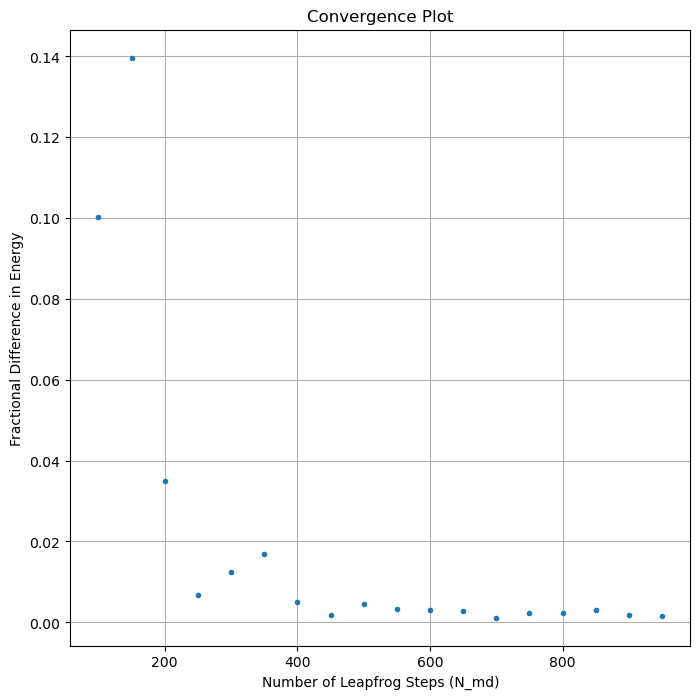

In [4]:
plt.figure(figsize=(8,8))
plt.xlabel('Number of Leapfrog Steps (N_md)')
plt.ylabel('Fractional Difference in Energy')
plt.title('Convergence Plot')
plt.grid()
plt.plot(range_1, diff,'.')
plt.show()

In [5]:
# Now we code the HMC algorithm

def markov_chain(L,N_cfg,N_md,beta,J,n_therm):
    chain = []
    M_arr=[]
    E_arr=[]
    for k in range(n_therm):
            # print(k/n_therm)
            p_hmc = np.random.normal(size=(N,N))
            new = leapfrog_2D(N_md, p_hmc,J, L,beta) # Integrating leapfrog algorithm
            prob = np.exp(Hamiltonian2D_art(J,L,p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))
            if prob > np.random.uniform(0,1):   # Accept/reject
                L=new[1] 
                
                
        
    for i in range(N_cfg):
            # print(i/N_cfg)
            chain.append(L)
            # print(chain[-1])
            p_hmc = np.random.normal(size=(N,N))
            new = leapfrog_2D(N_md, p_hmc,J, L,beta) # Integrating leapfrog algorithm
            prob = np.exp(Hamiltonian2D_art(J,chain[-1],p_hmc,beta)-Hamiltonian2D_art(J,new[1],new[0],beta))
            #  Given probability distribution function defined above
            if prob < np.random.uniform(0,1):   # Accept/reject
#                 chain.append(new[1]) 
                M_arr.append(sum(sum(abs(new[1])))/N**2)
                E = Hamiltonian2D(J,new[1])
                E_arr.append(E)
                
            else:                            
                  M_arr.append(sum(sum(L))/N**2)
                  E = Hamiltonian2D(J,L)  
                  E_arr.append(E)
    return np.mean(M_arr),np.mean(E_arr)



In [6]:
N_cfg = 5
n_therm = 10
beta_range = np.arange(1,11,1) 
# beta = 1 / kb * T
mag_5 = []
E_5 = []
for beta in beta_range:
    mag_ , E_ =markov_chain(L,N_cfg,N_md,beta,J,n_therm)
    mag_5.append(mag_)
    E_5.append(E_)


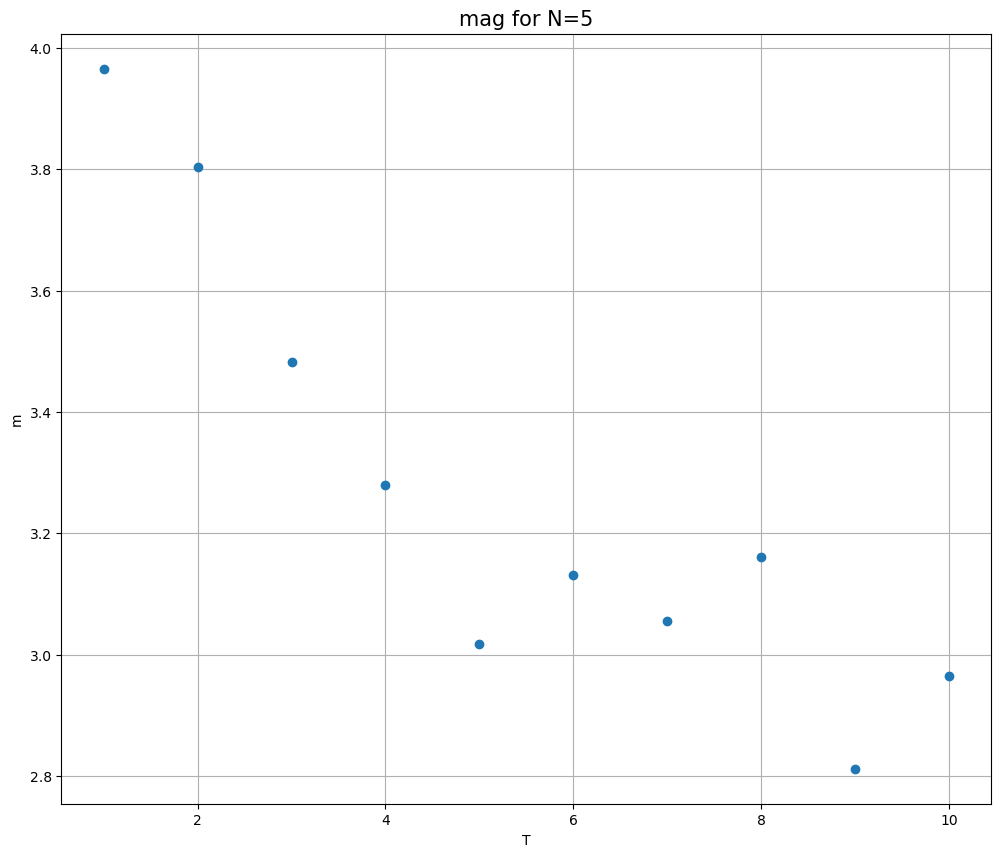

In [7]:
plt.figure(figsize=(12,10))
plt.grid()
plt.xlabel("T")
plt.ylabel("m")
plt.title("mag for N=5", fontsize =15)
plt.plot(beta_range, mag_5,"o")

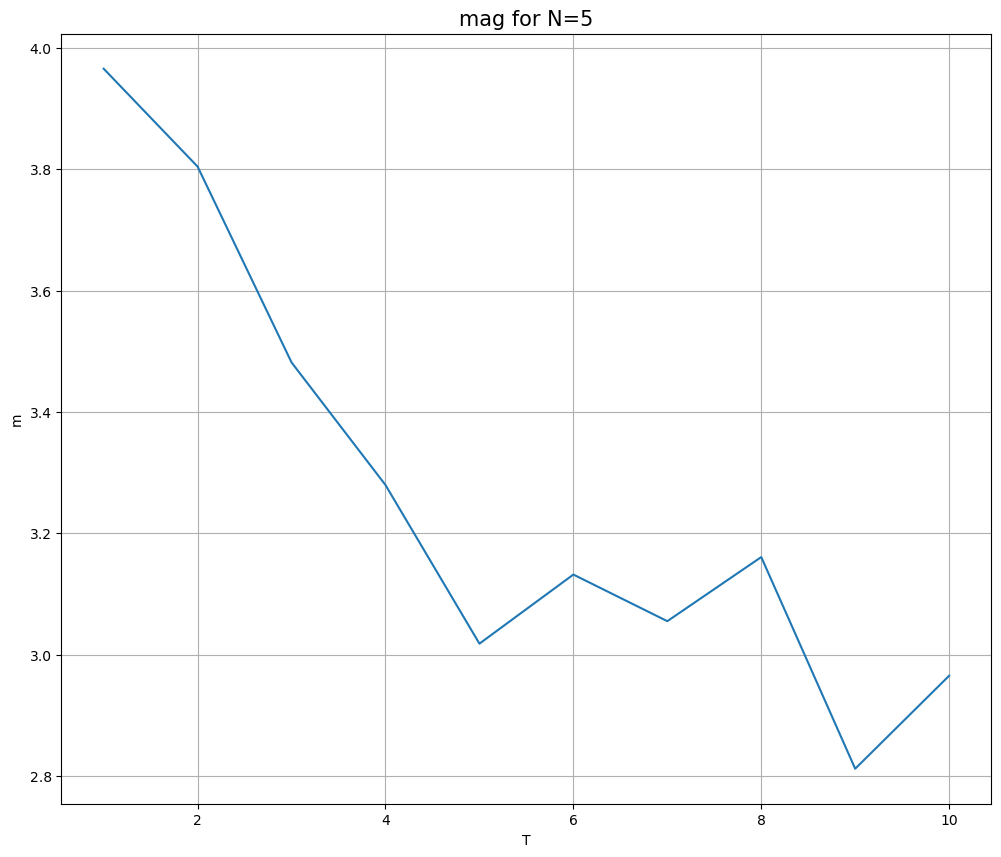

In [8]:
plt.figure(figsize=(12,10))
plt.grid()
plt.xlabel("T")
plt.ylabel("m")
plt.title("mag for N=5", fontsize =15)
plt.plot(beta_range, mag_5)